In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
from mtcnn import MTCNN

from tensorflow import keras as keras
from keras.models import load_model
from keras.preprocessing import image

In [2]:
# Load model
MODEL_PATH = '/home/leviathan/ml/mask_recognition/mask_recognition_model/'
MASKED_IMG_PATH = '/home/leviathan/ml/masked.jpeg'
FACE_IMG_PATH = '/home/leviathan/ml/face.jpeg'

IMG_HEIGHT = 224
IMG_WIDTH = 224

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

trained_model = tf.keras.models.load_model(MODEL_PATH)
trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

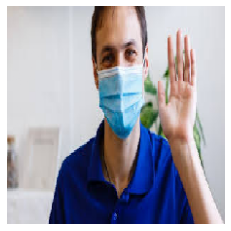

[1]
[[6.7491712e-08 9.9999833e-01]]


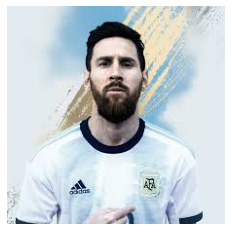

[0]
[[9.9998200e-01 1.4641208e-06]]


In [3]:
# Predict images
masked_image = load_image(MASKED_IMG_PATH, True)
masked_classes = trained_model.predict(masked_image)
masked_classes_label = masked_classes.argmax(axis=-1)
print(masked_classes_label)
print(masked_classes)

face_image = load_image(FACE_IMG_PATH, True)
face_classes = trained_model.predict(face_image)
face_classes_label = face_classes.argmax(axis=-1)
print(face_classes_label)
print(face_classes)

unmasked: 0.999982


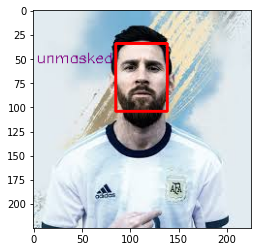

In [4]:
# Show results by plt
detector = MTCNN()
text = ""

# Show unmasked
cv_face_image = cv2.cvtColor(cv2.imread(FACE_IMG_PATH), cv2.COLOR_BGR2RGB)
face_locs = detector.detect_faces(cv_face_image)
bbox = face_locs[0]['box']
start_x = bbox[0]
start_y = bbox[1]
end_x = bbox[0] + bbox[2]
end_y = bbox[1] + bbox[3]

result = trained_model.predict(face_image)
is_masked = result.argmax(axis=-1)
if is_masked:
    text = "masked"
else:
    text = "unmasked"

color = (36,255,12) if is_masked else (255, 0, 0)
    
re_image = cv2.rectangle(cv_face_image, (start_x, start_y), (end_x, end_y), color, 2)
cv2.putText(re_image, text, (end_x-135, end_y-50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (128, 0, 128), 1)
print("%s: %f" % (text, face_classes[0][face_classes_label][0]))
plt.imshow(re_image)

masked: 0.999998


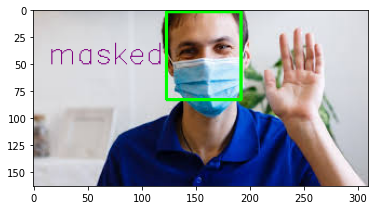

In [5]:
# Show masked
cv_masked_img = cv2.cvtColor(cv2.imread(MASKED_IMG_PATH), cv2.COLOR_BGR2RGB)
face_locs = detector.detect_faces(cv_masked_img)
bbox = face_locs[0]['box']
start_x = bbox[0]
start_y = bbox[1]
end_x = bbox[0] + bbox[2]
end_y = bbox[1] + bbox[3]

result = trained_model.predict(masked_image)
is_masked = result.argmax(axis=-1)
if is_masked:
    text = "masked"
else:
    text = "unmasked"
    
color = (0,255,0) if is_masked else (255, 0, 0)
    
re_image = cv2.rectangle(cv_masked_img, (start_x, start_y), (end_x, end_y), color, 2)
cv2.putText(re_image, text, (13, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (128, 0, 128), 1)
print(f'%s: %f' % (text, masked_classes[0][masked_classes_label][0]))
plt.imshow(re_image)